In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install dask-ml --quiet
!pip install dask --quiet
!pip install kmodes --quiet
!pip install gower --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#df_init = pd.read_csv('/content/drive/MyDrive/df_base.csv', low_memory = False)
#df_init['fecha_suceso'] = pd.to_datetime(df_init['fecha_suceso'])
iter_csv = pd.read_csv('/content/drive/MyDrive/df_base.csv', iterator=True, chunksize=1000)
df = pd.concat([chunk[pd.to_datetime(chunk['fecha_suceso']).dt.year  >= 2016] for chunk in iter_csv])
pd.set_option('display.max_columns', None)
df.head()

,num_denuncia,fecha_suceso,hora_suceso,direccion_suceso,fecha_denuncia,delito_completado_interrumpido,nivel_ofensa,distrito,jurisdiccion_encargada,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,geoespacial,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,diff_dias_hecho_denuncia,dia_suceso,estacion_suceso,mes_suceso
0,506547392,2018-03-29,Noche,32.0,2018-03-30,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,UNKNOWN,UNKNOWN,Desconocido,"(40.810877241, -73.941064151)",25-44,WHITE,Femenino,incidentes_menores,lugares solitarios,1,jueves,primavera,abril
1,629632833,2018-02-06,Noche,52.0,2018-02-07,COMPLETED,MISDEMEANOR,BRONX,Policia,45-64,BLACK,Femenino,"(40.873671035, -73.908013649)",UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,1,martes,invierno,marzo
2,787203902,2018-11-21,Madrugada,75.0,2018-11-21,COMPLETED,MISDEMEANOR,BROOKLYN,Policia,25-44,WHITE,Femenino,"(40.651782232, -73.885456761)",UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares publicos,0,miercoles,otono,diciembre
3,280364018,2018-06-09,Noche,10.0,2018-06-10,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,25-44,WHITE,Masculino,"(40.759310399, -73.994706072)",UNKNOWN,WHITE,Femenino,incidentes_menores,lugares publicos,1,sabado,verano,julio
4,985800320,2018-11-10,Noche,19.0,2018-11-10,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,<18,BLACK,Femenino,"(40.764535539, -73.970728388)",UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,0,sabado,otono,diciembre


Acotaremos el ejercicio a los distritos donde más casos hubieron

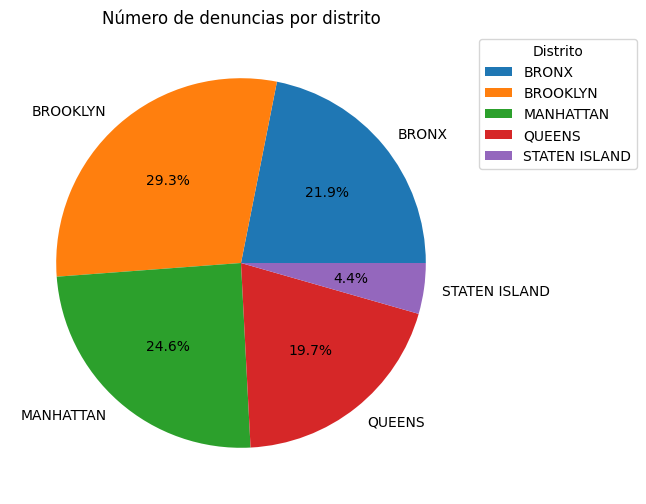

In [ ]:
distritos_counts = df.groupby(['distrito']).size()

# Crear un gráfico de torta
plt.figure(figsize=(6, 6))
distritos_counts.plot.pie(autopct='%1.1f%%')
plt.title('Número de denuncias por distrito')
plt.legend(title='Distrito', labels=distritos_counts.index, bbox_to_anchor=(1, 1))
plt.show()

## BRONX

In [ ]:
df_bronx = df[df.distrito == 'BRONX'].copy()
df_bronx.reset_index(inplace = True, drop = True)
df_bronx['direccion_suceso'] = df_bronx['direccion_suceso'].astype('object')

In [ ]:
df_bronx.drop(columns= ['fecha_suceso', 'fecha_denuncia', 'num_denuncia', 'direccion_suceso', 'distrito', 'diff_dias_hecho_denuncia', 'nivel_ofensa','delito_completado_interrumpido'], inplace = True)

Separamos coordenadas

In [ ]:
df_bronx['latitud'] = df_bronx.geoespacial.apply(lambda x: float(x.replace('(', '').replace(')', '').split(',')[0]))
df_bronx['longitud'] = df_bronx.geoespacial.apply(lambda x: float(x.replace('(', '').replace(')', '').split(',')[1]))
df_bronx.drop(columns= ['geoespacial'], inplace = True)
df_bronx.head()

,hora_suceso,jurisdiccion_encargada,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso,latitud,longitud
0,Noche,Policia,45-64,BLACK,Femenino,UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,martes,invierno,marzo,40.873671,-73.908014
1,Noche,Policia,25-44,BLACK,Masculino,UNKNOWN,UNKNOWN,Transgenero,incidentes_menores,diversion y turismo,miercoles,otono,octubre,40.853653,-73.906892
2,Noche,Policia,45-64,WHITE,Masculino,25-44,WHITE,Femenino,delitos_graves,lugares publicos,sabado,verano,septiembre,40.826170,-73.916831
3,Tarde,Policia,UNKNOWN,UNKNOWN,Desconocido,45-64,BLACK,Femenino,incidentes_menores,lugares publicos,domingo,invierno,marzo,40.827049,-73.894994
4,Noche,Policia,UNKNOWN,UNKNOWN,Desconocido,25-44,ASIAN / PACIFIC ISLANDER,Femenino,incidentes_menores,lugares publicos,miercoles,primavera,junio,40.882615,-73.851948


In [ ]:
from sklearn.preprocessing import MinMaxScaler
num_cols = df_bronx.select_dtypes('number')
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(num_cols), columns = num_cols.columns.tolist())
df_bronx_ready = pd.concat([df_bronx.drop(columns = num_cols.columns.tolist()), scaled], axis = 1)
df_bronx_ready_sample =df_bronx_ready.sample(frac = 0.2, replace = True, random_state=1234)

## **1ra iteración:** de 2016 a 2019
- Sin reducción de de dimensionalidad y aplicación de KMeans y Spectral Clustering.

## **2da iteración:** De 2016 a 2019 y distrito con mayor número de casos
- Sin reducción de dimensionalidad y KModes.

### 1.1.1 Sin reducción de dimensionalidad y aplicación de KMeans.

Método del codo

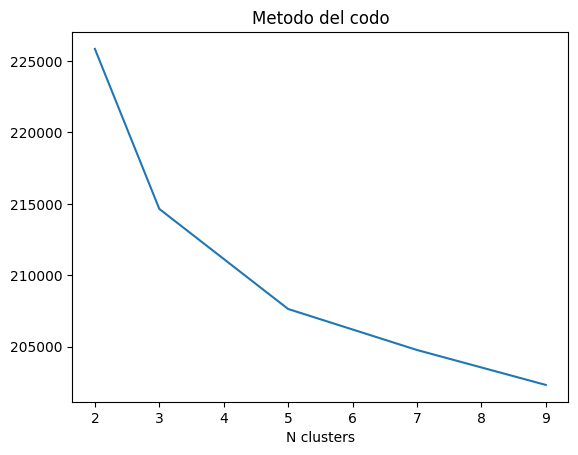

In [ ]:
from sklearn.metrics import silhouette_score  
from dask_ml.cluster import KMeans as KMeansDask
import dask.dataframe as da

# crear matriz Dask
sample = df_bronx_ready_sample.copy()
dummies = pd.get_dummies(sample)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
n_clusters = [2,3,5,7,9]
km = []
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(X)
  km.append(kmeans.inertia_)

plt.title('Metodo del codo')
plt.xlabel('N clusters')
plt.plot(n_clusters, km)
plt.show()


### Cohesión y Separabilidad con KMeans y n clusters
- **Calinski-Harabasz:** cuanto mayor sea el valor del índice  se considera que el clustering es mejor.

- **Silhoutte Score:** Un valor cercano a 1 indica que las muestras están bien asignadas a sus clusters y están alejadas de los otros clusters vecinos. Un valor cercano a 0 indica que las muestras están en o cerca del límite de decisión entre dos clusters vecinos. Un valor cercano a -1 indica que las muestras pueden haber sido asignadas incorrectamente a sus clusters y que están más cerca de los otros clusters vecinos.

In [ ]:
from sklearn import metrics
sample = df_bronx_ready_sample.copy()
dummies = pd.get_dummies(sample)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
n_clusters = [2,3,5,7,9]
km = []
metrics_df_general = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(X) 
  labels = kmeans.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(X, labels)
  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(X, labels)
  metrics_df = pd.DataFrame({'Metodo': ['KMeans'],
                           'k':[k],
                           'Calinski-Harabasz Index': [ch_score],
                           'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general = metrics_df_general.append(metrics_df, ignore_index=True)
metrics_df_general

,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KMeans,2,8880.606503,0.093576
1,KMeans,3,7835.419454,0.102561
2,KMeans,5,5382.366464,0.074459
3,KMeans,7,4221.401989,0.064865
4,KMeans,9,3526.144750,0.068789


In [ ]:
from dask_ml.cluster import KMeans as KMeansDask
import dask.dataframe as da

# crear matriz Dask
dummies = pd.get_dummies(df_bronx_ready)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
kmeans = KMeansDask(n_clusters=3, random_state=1234)
kmeans.fit(X)


KMeans(n_clusters=3, random_state=1234)

### Centroides con KMeans y clusters igual a 3

In [ ]:
kmeans = KMeansDask(n_clusters=3, random_state = 1234)
kmeans.fit(X)
centroids = kmeans.cluster_centers_ 
labels = kmeans.labels_ 

In [ ]:
centroides_bronx = pd.DataFrame(centroids, columns = pd.get_dummies(df_bronx_ready_sample).columns.tolist())
centroides_bronx.reset_index(inplace = True, drop = False)
centroides_bronx.rename(columns = {'index':'cluster'}, inplace =True)
centroides_bronx

,cluster,latitud,longitud,hora_suceso_Madrugada,hora_suceso_Mañana,hora_suceso_Noche,hora_suceso_Tarde,jurisdiccion_encargada_Externas,jurisdiccion_encargada_Otras,jurisdiccion_encargada_Policia,jurisdiccion_encargada_Transito,jurisdiccion_encargada_Vivienda,grupo_edad_sospechoso_25-44,grupo_edad_sospechoso_45-64,grupo_edad_sospechoso_<18,grupo_edad_sospechoso_UNKNOWN,raza_sospechoso_AMERICAN INDIAN/ALASKAN NATIVE,raza_sospechoso_ASIAN / PACIFIC ISLANDER,raza_sospechoso_BLACK,raza_sospechoso_UNKNOWN,raza_sospechoso_WHITE,sexo_sospechoso_Desconocido,sexo_sospechoso_Femenino,sexo_sospechoso_Masculino,grupo_edad_victima_25-44,grupo_edad_victima_45-64,grupo_edad_victima_<18,grupo_edad_victima_UNKNOWN,raza_victima_AMERICAN INDIAN/ALASKAN NATIVE,raza_victima_ASIAN / PACIFIC ISLANDER,raza_victima_BLACK,raza_victima_UNKNOWN,raza_victima_WHITE,sexo_victima_Femenino,sexo_victima_Masculino,sexo_victima_Transgenero,tipo_crimen_armas_drogas,tipo_crimen_crimenes_sexuales,tipo_crimen_delitos_graves,tipo_crimen_extorsion,tipo_crimen_incidentes_menores,tipo_crimen_otros_crimenes,lugar_Otros,lugar_diversion y turismo,lugar_lugares publicos,lugar_lugares solitarios,lugar_necesidades diarias,dia_suceso_domingo,dia_suceso_jueves,dia_suceso_lunes,dia_suceso_martes,dia_suceso_miercoles,dia_suceso_sabado,dia_suceso_viernes,estacion_suceso_invierno,estacion_suceso_otono,estacion_suceso_primavera,estacion_suceso_verano,mes_suceso_abril,mes_suceso_agosto,mes_suceso_diciembre,mes_suceso_febrero,mes_suceso_julio,mes_suceso_junio,mes_suceso_marzo,mes_suceso_mayo,mes_suceso_noviembre,mes_suceso_octubre,mes_suceso_septiembre
0,0,0.786729,0.585478,0.165833,0.210053,0.300768,0.323346,0.000022,0.005003,0.871880,0.012716,0.110379,0.436899,0.139222,0.062374,0.361506,0.002893,0.012727,0.594065,0.043553,0.346762,0.010314,0.269821,0.719865,0.484248,0.222455,0.087321,0.205976,0.004634,0.025945,0.493135,0.047388,0.428899,0.642346,0.357412,0.000242,0.003559,0.315154,0.354134,0.130539,0.171976,0.024639,0.022402,0.054842,0.853302,0.021537,0.047917,0.146979,0.138401,0.144357,0.141172,0.141299,0.142582,0.145211,0.230157,0.249017,0.252388,0.268438,0.081531,0.091173,0.156786,0.080104,0.088693,0.088958,0.071575,0.081900,0.085806,0.084903,0.088572
1,1,0.793163,0.588676,0.156468,0.200438,0.332192,0.310903,0.000008,0.004056,0.926384,0.011300,0.058252,0.002352,0.001483,0.001713,0.994453,0.000098,0.000459,0.013479,0.974852,0.011111,0.907521,0.034006,0.058474,0.465650,0.283625,0.047813,0.202912,0.006736,0.034268,0.451048,0.075780,0.432169,0.447205,0.550771,0.002024,0.001442,0.091742,0.104279,0.565471,0.230412,0.006654,0.023984,0.066709,0.828316,0.032687,0.048305,0.136318,0.139235,0.147684,0.142923,0.142071,0.141366,0.150404,0.230518,0.258895,0.243785,0.266802,0.077894,0.088612,0.166358,0.077984,0.086801,0.085629,0.068938,0.080262,0.088735,0.087399,0.091390
2,2,0.780012,0.580529,0.152670,0.158209,0.326306,0.362815,0.000020,0.043967,0.819773,0.041547,0.094693,0.320894,0.123362,0.031896,0.523848,0.001151,0.007723,0.417319,0.305488,0.268319,0.284965,0.115186,0.599848,0.000059,0.000315,0.000118,0.999508,0.000098,0.000679,0.001623,0.996202,0.001397,0.016017,0.027931,0.956052,0.317727,0.022303,0.031846,0.361340,0.239335,0.027449,0.062188,0.246163,0.580103,0.046063,0.065483,0.117626,0.152995,0.117272,0.146570,0.159409,0.145478,0.160649,0.239257,0.244687,0.258628,0.257428,0.085121,0.087403,0.149128,0.087915,0.081225,0.090079,0.077683,0.083428,0.085770,0.083448,0.088800


In [ ]:
bronx_kmeans_sin_reduccion = df_bronx_ready.copy()
bronx_kmeans_sin_reduccion['clusters'] = kmeans.labels_

### Análisis de clusters en KMeans sin reducción

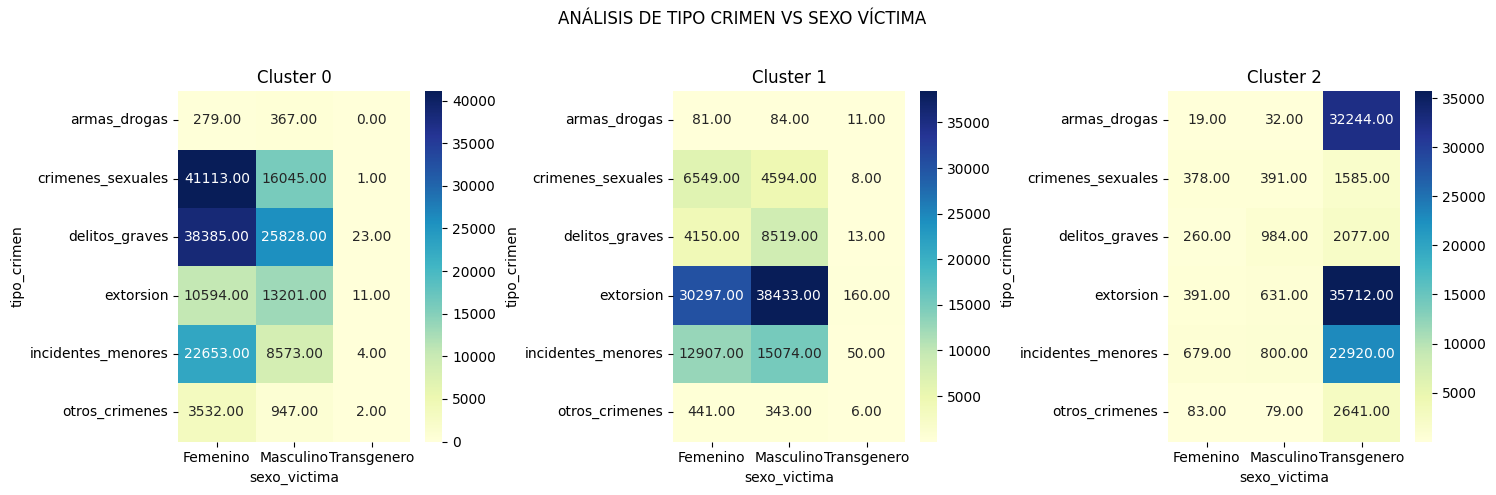

In [ ]:
bronx_cluster0 = bronx_kmeans_sin_reduccion[bronx_kmeans_sin_reduccion['clusters']==0]
bronx_cluster1 = bronx_kmeans_sin_reduccion[bronx_kmeans_sin_reduccion['clusters']==1]
bronx_cluster2 = bronx_kmeans_sin_reduccion[bronx_kmeans_sin_reduccion['clusters']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(bronx_cluster0['tipo_crimen'], bronx_cluster0['sexo_victima'])
ct1 = pd.crosstab(bronx_cluster1['tipo_crimen'], bronx_cluster1['sexo_victima'])
ct2 = pd.crosstab(bronx_cluster2['tipo_crimen'], bronx_cluster2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

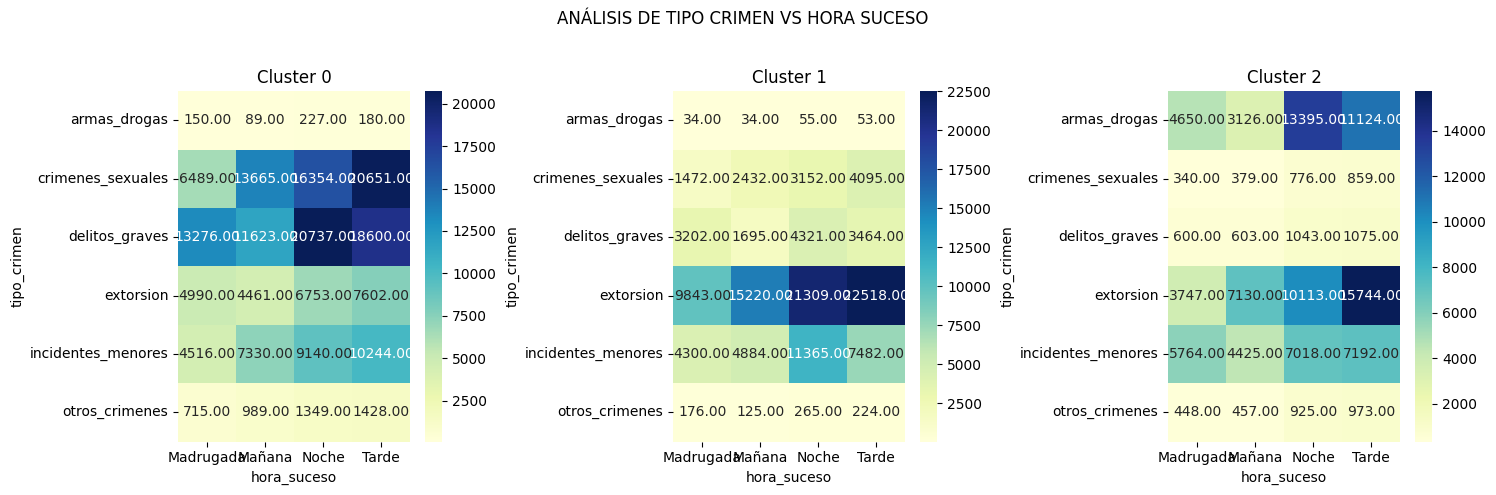

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(bronx_cluster0['tipo_crimen'], bronx_cluster0['hora_suceso'])
ct1 = pd.crosstab(bronx_cluster1['tipo_crimen'], bronx_cluster1['hora_suceso'])
ct2 = pd.crosstab(bronx_cluster2['tipo_crimen'], bronx_cluster2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

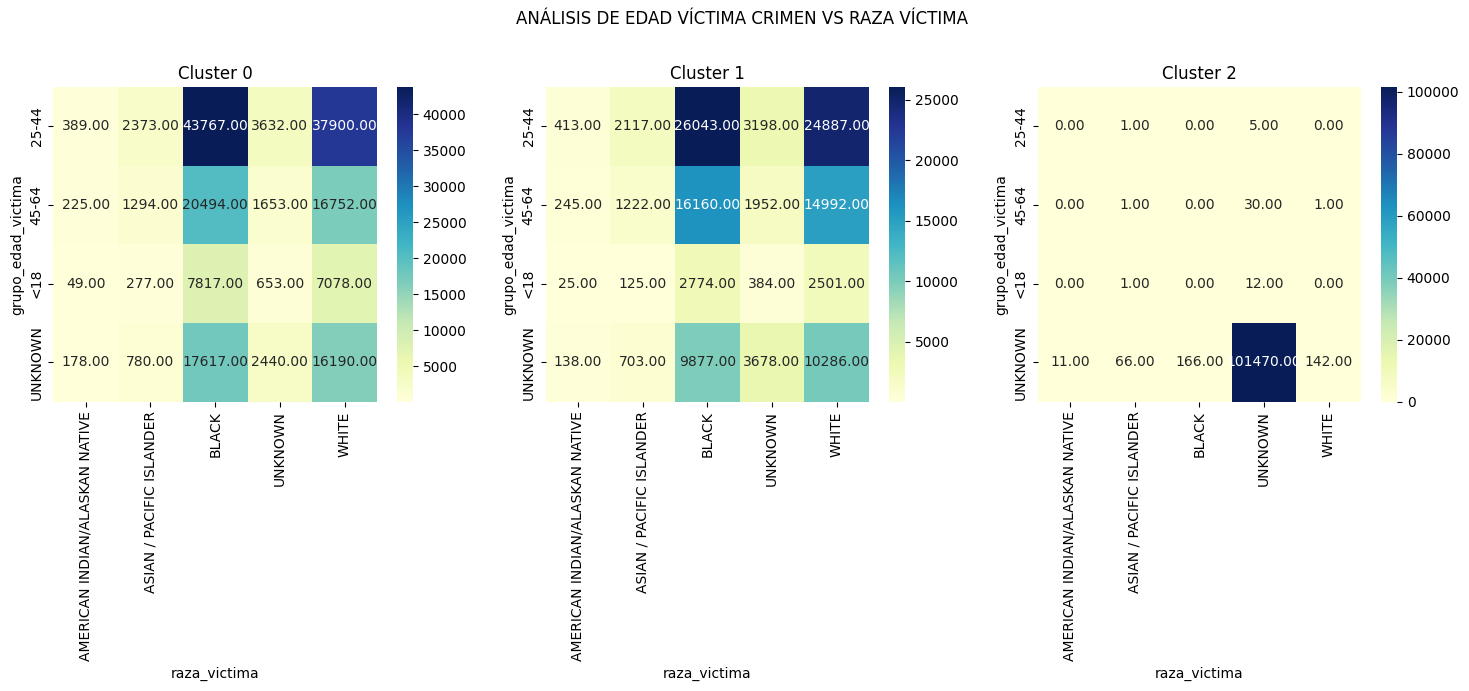

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(bronx_cluster0['grupo_edad_victima'], bronx_cluster0['raza_victima'])
ct1 = pd.crosstab(bronx_cluster1['grupo_edad_victima'], bronx_cluster1['raza_victima'])
ct2 = pd.crosstab(bronx_cluster2['grupo_edad_victima'], bronx_cluster2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

In [ ]:
for column in bronx_kmeans_sin_reduccion.columns:
  if column not in ['clusters', 'latitud', 'longitud']:
    print(f"Variable {column}:")
    display(bronx_kmeans_sin_reduccion.groupby(['clusters', column]).size().reset_index().rename(columns = {0:'casos'}))
    print('\n')

Variable hora_suceso:


,clusters,hora_suceso,casos
0,0,Madrugada,30136
1,0,Mañana,38157
2,0,Noche,54560
3,0,Tarde,58705
4,1,Madrugada,19027
5,1,Mañana,24390
6,1,Noche,40467
7,1,Tarde,37836
8,2,Madrugada,15549
9,2,Mañana,16120




Variable jurisdiccion_encargada:


,clusters,jurisdiccion_encargada,casos
0,0,Externas,4
1,0,Otras,883
2,0,Policia,158285
3,0,Transito,2313
4,0,Vivienda,20073
5,1,Externas,1
6,1,Otras,495
7,1,Policia,112812
8,1,Transito,1373
9,1,Vivienda,7039




Variable grupo_edad_sospechoso:


,clusters,grupo_edad_sospechoso,casos
0,0,25-44,79153
1,0,45-64,25228
2,0,<18,11313
3,0,UNKNOWN,65864
4,1,25-44,282
5,1,45-64,175
6,1,<18,203
7,1,UNKNOWN,121060
8,2,25-44,32767
9,2,45-64,12586




Variable raza_sospechoso:


,clusters,raza_sospechoso,casos
0,0,AMERICAN INDIAN/ALASKAN NATIVE,528
1,0,ASIAN / PACIFIC ISLANDER,2322
2,0,BLACK,107756
3,0,UNKNOWN,8031
4,0,WHITE,62921
5,1,AMERICAN INDIAN/ALASKAN NATIVE,9
6,1,ASIAN / PACIFIC ISLANDER,42
7,1,BLACK,1636
8,1,UNKNOWN,118797
9,1,WHITE,1236




Variable sexo_sospechoso:


,clusters,sexo_sospechoso,casos
0,0,Desconocido,1907
1,0,Femenino,49039
2,0,Masculino,130612
3,1,Desconocido,110713
4,1,Femenino,4020
5,1,Masculino,6987
6,2,Desconocido,28969
7,2,Femenino,11772
8,2,Masculino,61165




Variable grupo_edad_victima:


,clusters,grupo_edad_victima,casos
0,0,25-44,88061
1,0,45-64,40418
2,0,<18,15874
3,0,UNKNOWN,37205
4,1,25-44,56658
5,1,45-64,34571
6,1,<18,5809
7,1,UNKNOWN,24682
8,2,25-44,6
9,2,45-64,32




Variable raza_victima:


,clusters,raza_victima,casos
0,0,AMERICAN INDIAN/ALASKAN NATIVE,841
1,0,ASIAN / PACIFIC ISLANDER,4724
2,0,BLACK,89695
3,0,UNKNOWN,8378
4,0,WHITE,77920
5,1,AMERICAN INDIAN/ALASKAN NATIVE,821
6,1,ASIAN / PACIFIC ISLANDER,4167
7,1,BLACK,54854
8,1,UNKNOWN,9212
9,1,WHITE,52666




Variable sexo_victima:


,clusters,sexo_victima,casos
0,0,Femenino,116556
1,0,Masculino,64961
2,0,Transgenero,41
3,1,Femenino,54425
4,1,Masculino,67047
5,1,Transgenero,248
6,2,Femenino,1810
7,2,Masculino,2917
8,2,Transgenero,97179




Variable tipo_crimen:


,clusters,tipo_crimen,casos
0,0,armas_drogas,646
1,0,crimenes_sexuales,57159
2,0,delitos_graves,64236
3,0,extorsion,23806
4,0,incidentes_menores,31230
5,0,otros_crimenes,4481
6,1,armas_drogas,176
7,1,crimenes_sexuales,11151
8,1,delitos_graves,12682
9,1,extorsion,68890




Variable lugar:


,clusters,lugar,casos
0,0,Otros,4046
1,0,diversion y turismo,9966
2,0,lugares publicos,154927
3,0,lugares solitarios,3917
4,0,necesidades diarias,8702
5,1,Otros,2921
6,1,diversion y turismo,8125
7,1,lugares publicos,100811
8,1,lugares solitarios,3980
9,1,necesidades diarias,5883




Variable dia_suceso:


,clusters,dia_suceso,casos
0,0,domingo,26699
1,0,jueves,25108
2,0,lunes,26223
3,0,martes,25617
4,0,miercoles,25648
5,0,sabado,25904
6,0,viernes,26359
7,1,domingo,16592
8,1,jueves,16953
9,1,lunes,17969




Variable estacion_suceso:


,clusters,estacion_suceso,casos
0,0,invierno,41776
1,0,otono,45196
2,0,primavera,45787
3,0,verano,48799
4,1,invierno,28072
5,1,otono,31528
6,1,primavera,29696
7,1,verano,32424
8,2,invierno,24377
9,2,otono,24939




Variable mes_suceso:


,clusters,mes_suceso,casos
0,0,abril,14785
1,0,agosto,16571
2,0,diciembre,28465
3,0,febrero,14535
4,0,julio,16128
5,0,junio,16143
6,0,marzo,12988
7,0,mayo,14859
8,0,noviembre,15573
9,0,octubre,15411


### 1.2 Con reducción de dimensionalidad y aplicación de KMeans.

In [ ]:
from dask_ml.decomposition import PCA

dummies = pd.get_dummies(df_bronx_ready_sample, dtype ='int')
# crear matriz Dask
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 

# crear objeto PCA
pca = PCA(n_components=X.shape[1])

# ajustar el modelo
pca.fit(X)

PCA(n_components=68)

In [ ]:
pca.explained_variance_ratio_[:40].sum(axis = 0)

0.9763961330391382

In [ ]:
pca = PCA(n_components=40)
X_PCA =pca.fit_transform(X)
#X_PCA = X_PCA.compute() 

In [ ]:
X_PCA_ok = pd.DataFrame(X_PCA, columns = ['component'+str(column) for column in range(X_PCA.shape[1])])
X_PCA_ok.head()

,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,component10,component11,component12,component13,component14,component15,component16,component17,component18,component19,component20,component21,component22,component23,component24,component25,component26,component27,component28,component29,component30,component31,component32,component33,component34,component35,component36,component37,component38,component39
0,-1.456313,-1.291632,0.180273,-0.237426,0.117259,-0.527010,-0.545326,-0.728430,0.516479,-0.207555,-0.151836,-0.242650,-0.369609,0.670766,-0.537724,0.871965,-0.206953,0.011580,0.270427,-0.254234,-0.837045,0.083445,0.208182,-0.198982,0.134660,0.385009,-0.101604,-0.090868,-0.404841,0.248738,0.332479,0.304220,-0.008531,0.590347,-0.180790,0.259131,-0.029815,0.004559,-0.175894,-0.009539
1,-0.650047,0.442061,-0.026446,-1.044244,1.183320,-0.355096,0.433790,-0.382856,0.118384,0.002615,0.298295,-0.400156,-0.323154,0.825106,0.743773,-0.098805,0.015315,0.061176,0.012353,-0.009637,0.079413,-0.283827,0.444812,0.211854,0.779935,-0.704342,-0.055581,0.115729,0.136835,-0.021346,0.079310,0.158704,-0.244871,-0.354516,0.046616,0.752461,-0.119061,-0.067738,-0.082666,0.163571
2,1.558401,0.008710,-0.191481,-0.608322,-0.189646,-0.116428,1.292508,0.116438,0.670337,-0.427798,0.276580,-0.411148,-0.194031,0.130289,-0.002733,0.060515,-0.165711,-0.202358,0.134499,-0.176509,0.072820,0.081967,-0.818988,-0.127119,0.164387,0.010780,-0.211982,0.072728,0.000792,-0.452385,-0.531543,0.391545,-0.554146,-0.070584,-0.436299,-0.242322,0.077244,-0.114072,0.288769,0.091414
3,-0.662913,-1.554037,0.525073,-0.152191,0.742078,-0.398947,0.073954,-0.814512,0.969823,0.450718,0.446957,0.682820,-0.439047,-0.267379,-0.341203,0.110337,0.081659,-0.016272,0.201799,0.222728,0.074121,0.218736,-0.789761,0.067000,0.231920,0.317577,-0.490259,-0.320446,0.328696,-0.254805,-0.353355,-0.506554,0.304688,0.180949,0.091212,0.264597,-0.068153,-0.001201,-0.140112,-0.045384
4,1.342290,0.449481,0.354891,0.991877,0.392773,1.034542,0.118330,-0.158138,0.348153,-0.510942,0.106364,-0.389913,0.654997,-0.004854,0.082318,-0.213870,0.145291,0.014986,0.107377,0.297821,-0.107637,0.026554,-0.125703,0.650821,-0.192619,-0.092720,0.392311,-0.029895,-0.127176,-0.628272,0.428974,-0.050378,0.009159,-0.083014,0.052396,-0.088850,-0.070336,-0.049400,-0.004116,-0.035578


Según el método del codo, cuántos cluster serían una elección óptima?

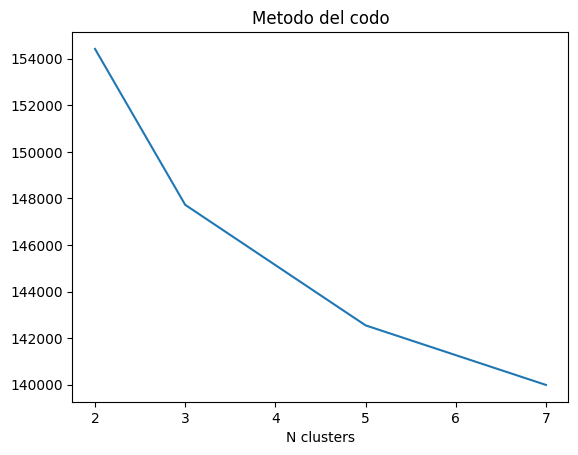

In [ ]:
n_clusters = [2, 3, 5, 7]

km = []
sample = X_PCA_ok.sample(frac = 0.7)
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(sample)
  km.append(kmeans.inertia_)

plt.title('Metodo del codo')
plt.xlabel('N clusters')
plt.plot(n_clusters, km)
plt.show()

### Calinski-Harabasz Index y Silhouette Coefficient para n clusters en KMeans con PCA

In [ ]:
metrics_df_general_pca = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])
n_clusters = [2,3,5,7,9]
km = []
sample = X_PCA_ok.sample(frac=0.3)
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(sample) 
  labels = kmeans.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(sample, labels)

  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(sample, labels)

  metrics_df = pd.DataFrame({'Metodo': ['KMeans_PCA'],
                            'k':[k],
                            'Calinski-Harabasz Index': [ch_score],
                            'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general_pca = metrics_df_general_pca.append(metrics_df, ignore_index=True)

metrics_df_general_pca

,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KMeans_PCA,2,2743.171438,0.096208
1,KMeans_PCA,3,2437.712752,0.105311
2,KMeans_PCA,5,1664.171340,0.075478
3,KMeans_PCA,7,1230.320330,0.069634
4,KMeans_PCA,9,1106.775308,0.063666


### Centroides con KMeans y PCA y clusters igual a 3

In [ ]:
kmeans = KMeansDask(n_clusters=3, random_state = 1234)
kmeans.fit(X_PCA_ok)
centroids = kmeans.cluster_centers_ 
labels_pca = kmeans.labels_ 

In [ ]:
centroides_brooklyn_pca = pd.DataFrame(centroids, columns = X_PCA_ok.columns.tolist())
centroides_brooklyn_pca.reset_index(inplace = True, drop = False)
centroides_brooklyn_pca.rename(columns = {'index':'cluster'}, inplace =True)
centroides_brooklyn_pca

,cluster,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,component10,component11,component12,component13,component14,component15,component16,component17,component18,component19,component20,component21,component22,component23,component24,component25,component26,component27,component28,component29,component30,component31,component32,component33,component34,component35,component36,component37,component38,component39
0,0,1.261413,0.097026,0.006316,0.003205,-0.002888,-0.006027,-0.020550,-0.002712,0.014183,-0.025617,0.028426,0.014242,0.039866,0.079545,0.062761,0.010197,-0.029713,0.017670,0.002222,-0.042451,0.002613,-0.006726,0.003461,0.009675,0.010115,0.003446,0.008925,0.036093,0.001739,-0.001109,-0.000008,0.002504,-0.000987,0.000347,0.000487,-0.012859,-0.014643,0.004787,0.027475,0.021476
1,1,-0.522164,0.702139,-0.007783,-0.039185,0.028407,0.016808,0.047362,0.002663,-0.015520,0.070642,-0.017779,-0.003436,-0.018622,-0.055150,-0.030618,0.008126,0.008344,-0.012350,0.002543,0.022879,-0.000149,0.001472,0.008302,-0.001518,0.041299,0.016951,0.007439,0.003236,-0.001064,0.000208,0.001493,-0.001383,0.003159,0.003617,0.002550,0.003990,0.014378,-0.003020,-0.002710,0.007671
2,2,-0.557549,-1.362551,0.006397,0.065887,-0.047101,-0.022783,-0.059994,-0.001540,0.010886,-0.095413,-0.001876,-0.010667,-0.013853,0.004348,-0.019495,-0.026457,0.020166,0.001142,-0.007138,0.009329,-0.002813,0.005305,-0.018836,-0.008698,-0.085336,-0.034195,-0.023739,-0.048268,-0.000157,0.000937,-0.002645,-0.000492,-0.004454,-0.006839,-0.005106,0.008053,-0.008313,-0.000270,-0.027547,-0.038935


In [ ]:
bronx_kmeans_con_reduccion = df_bronx_ready_sample.copy()
bronx_kmeans_con_reduccion['clusters'] = labels_pca

### Análisis de clusters en KMeans con reducción

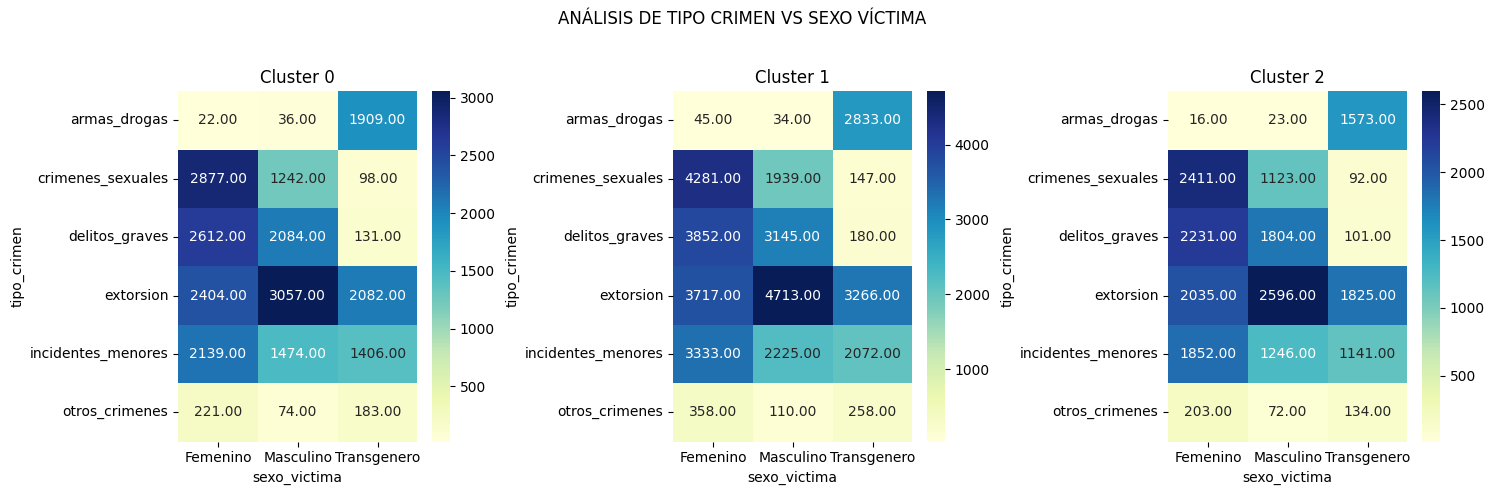

In [ ]:
bronx_cluster_pca0 = bronx_kmeans_con_reduccion[bronx_kmeans_con_reduccion['clusters']==0]
bronx_cluster_pca1 = bronx_kmeans_con_reduccion[bronx_kmeans_con_reduccion['clusters']==1]
bronx_cluster_pca2 = bronx_kmeans_con_reduccion[bronx_kmeans_con_reduccion['clusters']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(bronx_cluster_pca0['tipo_crimen'], bronx_cluster_pca0['sexo_victima'])
ct1 = pd.crosstab(bronx_cluster_pca1['tipo_crimen'], bronx_cluster_pca1['sexo_victima'])
ct2 = pd.crosstab(bronx_cluster_pca2['tipo_crimen'], bronx_cluster_pca2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

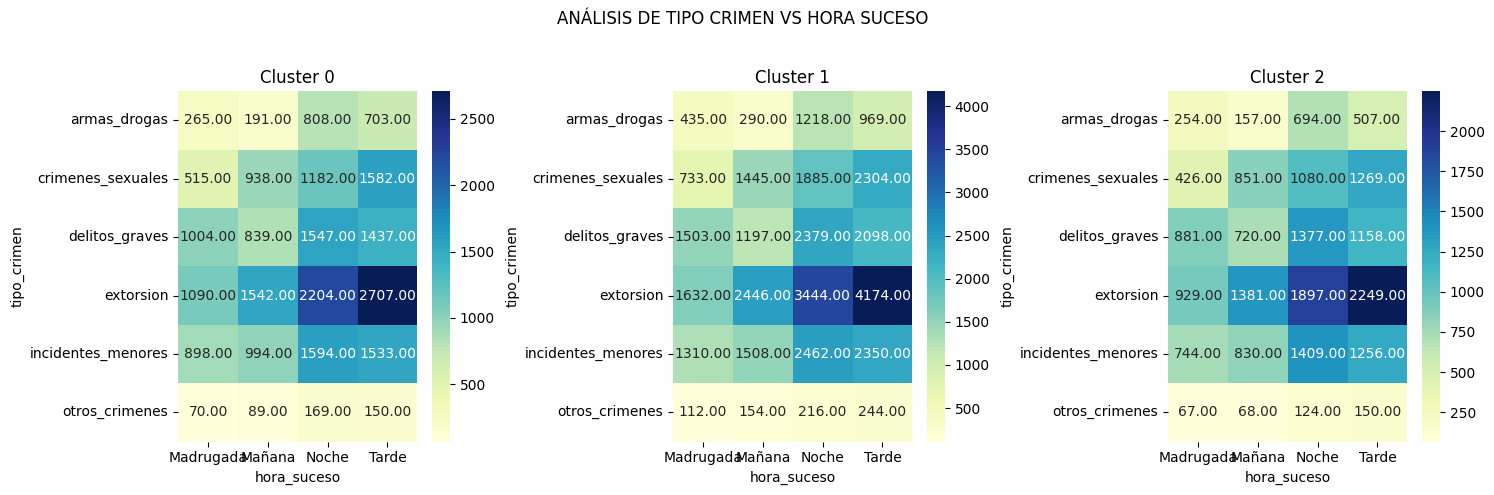

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(bronx_cluster_pca0['tipo_crimen'], bronx_cluster_pca0['hora_suceso'])
ct1 = pd.crosstab(bronx_cluster_pca1['tipo_crimen'], bronx_cluster_pca1['hora_suceso'])
ct2 = pd.crosstab(bronx_cluster_pca2['tipo_crimen'], bronx_cluster_pca2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

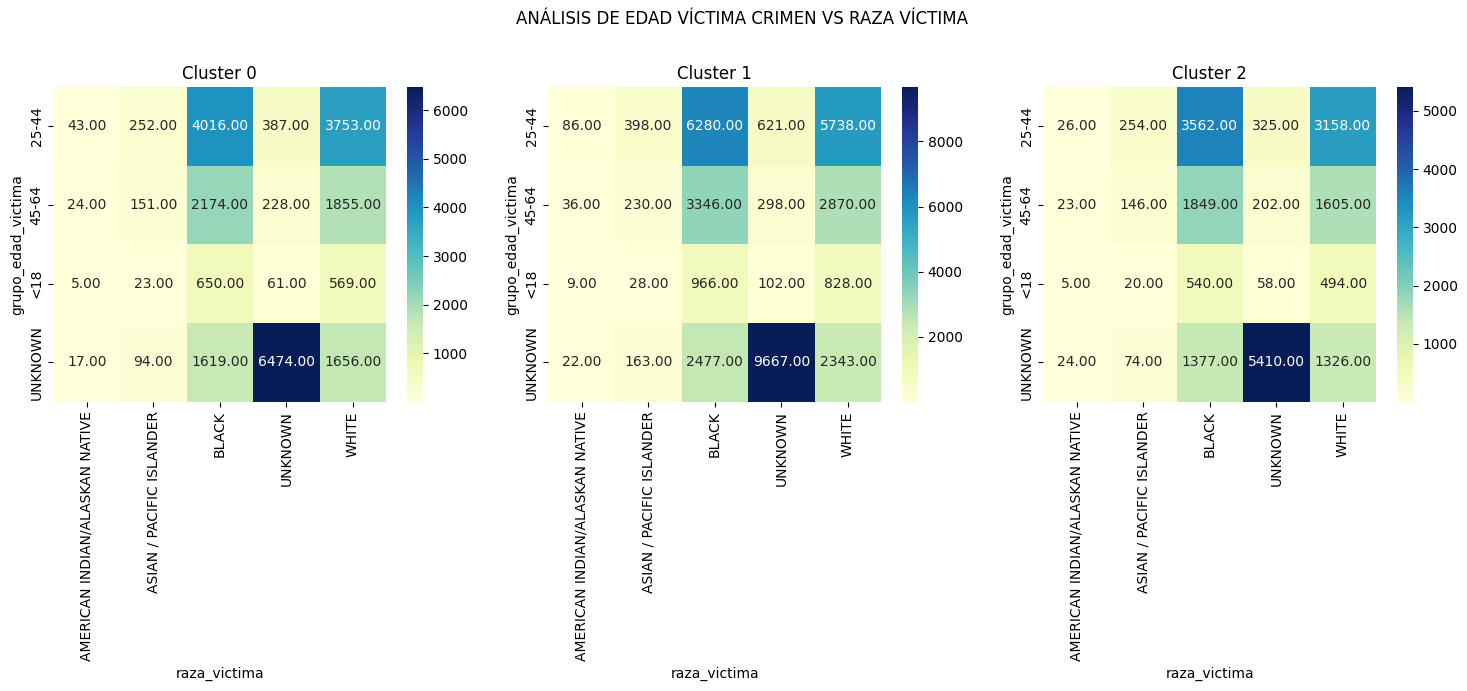

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(bronx_cluster_pca0['grupo_edad_victima'], bronx_cluster_pca0['raza_victima'])
ct1 = pd.crosstab(bronx_cluster_pca1['grupo_edad_victima'], bronx_cluster_pca1['raza_victima'])
ct2 = pd.crosstab(bronx_cluster_pca2['grupo_edad_victima'], bronx_cluster_pca2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

### **3. Sin reducción de dimensionalidad y aplicación de KModes.**

Se excluyen algunas variables para el análisis

In [ ]:
df_bronx_ready.drop(columns = ['jurisdiccion_encargada', 'latitud', 'longitud'], inplace = True)
df_bronx_ready_sample.drop(columns = ['jurisdiccion_encargada', 'latitud', 'longitud'], inplace = True)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.


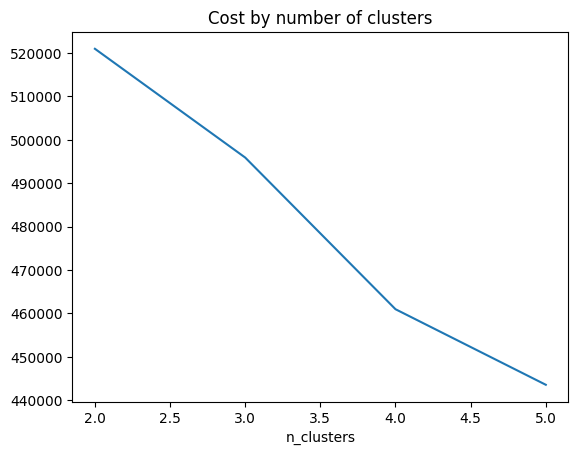

In [ ]:
from kmodes.kmodes import KModes
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_bronx = df_bronx_ready.copy()
categoricas_bronx_encoded = encoder.fit_transform(df_bronx_ready)

cost = []
n_clusters = [2,3,4,5]
for k in n_clusters:
  kmodes = KModes(n_clusters=k, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
  kmodes.fit(categoricas_bronx_encoded.sample(frac =0.2))
  cost.append(kmodes.cost_)

plt.title('Cost by number of clusters')
plt.xlabel('n_clusters')
plt.plot(n_clusters, cost)
plt.show()

In [ ]:
encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_bronx = df_bronx_ready.copy()
categoricas_bronx_encoded = encoder.fit_transform(df_bronx_ready)
metrics_df_general_kmodes = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])
sample = categoricas_bronx_encoded.sample(frac =0.5)
n_clusters = [2,3,4,5]
for k in n_clusters:
  kmodes = KModes(n_clusters=k, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
  kmodes.fit(sample)
  labels = kmodes.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(sample, labels)

  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(sample, labels)

  metrics_df = pd.DataFrame({'Metodo': ['KModes'],
                            'k':[k],
                            'Calinski-Harabasz Index': [ch_score],
                            'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general_kmodes = metrics_df_general_kmodes.append(metrics_df, ignore_index=True)
metrics_df_general_kmodes

Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.


,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KModes,2,9368.263846,0.054393
1,KModes,3,8458.086568,0.042282
2,KModes,4,4023.671543,-0.004884
3,KModes,5,5067.537325,0.005428


In [ ]:
from kmodes.kmodes import KModes
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_bronx = df_bronx_ready.copy()
categoricas_bronx_encoded = encoder.fit_transform(df_bronx_ready)

In [ ]:
kmodes = KModes(n_clusters=3, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
categoricas_bronx_encoded2 = categoricas_bronx_encoded.copy()
categoricas_bronx_encoded2['labels'] = kmodes.fit_predict(categoricas_bronx_encoded2)
categoricas_bronx['labels']  = categoricas_bronx_encoded2['labels'] 
categoricas_bronx.head()

Initialization method and algorithm are deterministic. Setting n_init to 1.


,hora_suceso,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso,labels
0,Noche,45-64,BLACK,Femenino,UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,martes,invierno,marzo,2
1,Noche,25-44,BLACK,Masculino,UNKNOWN,UNKNOWN,Transgenero,incidentes_menores,diversion y turismo,miercoles,otono,octubre,2
2,Noche,45-64,WHITE,Masculino,25-44,WHITE,Femenino,delitos_graves,lugares publicos,sabado,verano,septiembre,1
3,Tarde,UNKNOWN,UNKNOWN,Desconocido,45-64,BLACK,Femenino,incidentes_menores,lugares publicos,domingo,invierno,marzo,0
4,Noche,UNKNOWN,UNKNOWN,Desconocido,25-44,ASIAN / PACIFIC ISLANDER,Femenino,incidentes_menores,lugares publicos,miercoles,primavera,junio,0


### Centroides en KModes

In [ ]:
pd.DataFrame(encoder.inverse_transform(kmodes.cluster_centroids_), columns = categoricas_bronx_encoded.columns)

,hora_suceso,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso
0,Tarde,UNKNOWN,UNKNOWN,Desconocido,25-44,BLACK,Femenino,extorsion,lugares publicos,viernes,otono,diciembre
1,Noche,25-44,BLACK,Masculino,25-44,WHITE,Femenino,delitos_graves,lugares publicos,sabado,verano,agosto
2,Tarde,UNKNOWN,WHITE,Masculino,UNKNOWN,UNKNOWN,Transgenero,incidentes_menores,lugares publicos,martes,primavera,abril


### Análisis de clusters en KModes

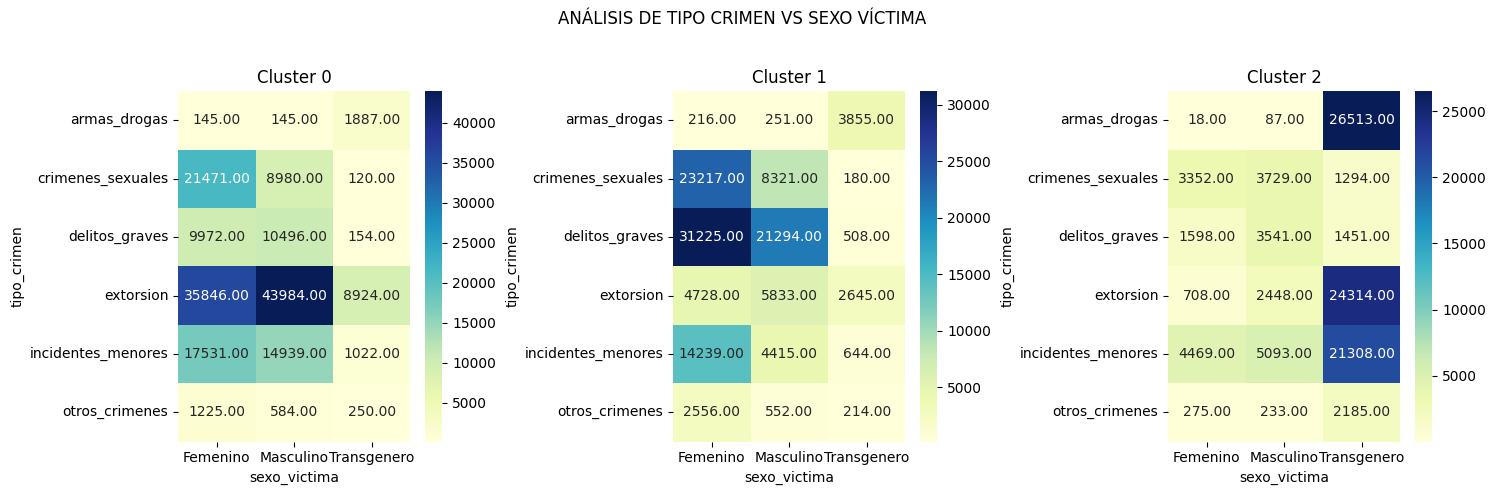

In [ ]:
bronx_cluster_kmodes0 = categoricas_bronx[categoricas_bronx['labels']==0]
bronx_cluster_kmodes1 = categoricas_bronx[categoricas_bronx['labels']==1]
bronx_cluster_kmodes2 = categoricas_bronx[categoricas_bronx['labels']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(bronx_cluster_kmodes0['tipo_crimen'], bronx_cluster_kmodes0['sexo_victima'])
ct1 = pd.crosstab(bronx_cluster_kmodes1['tipo_crimen'], bronx_cluster_kmodes1['sexo_victima'])
ct2 = pd.crosstab(bronx_cluster_kmodes2['tipo_crimen'], bronx_cluster_kmodes2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

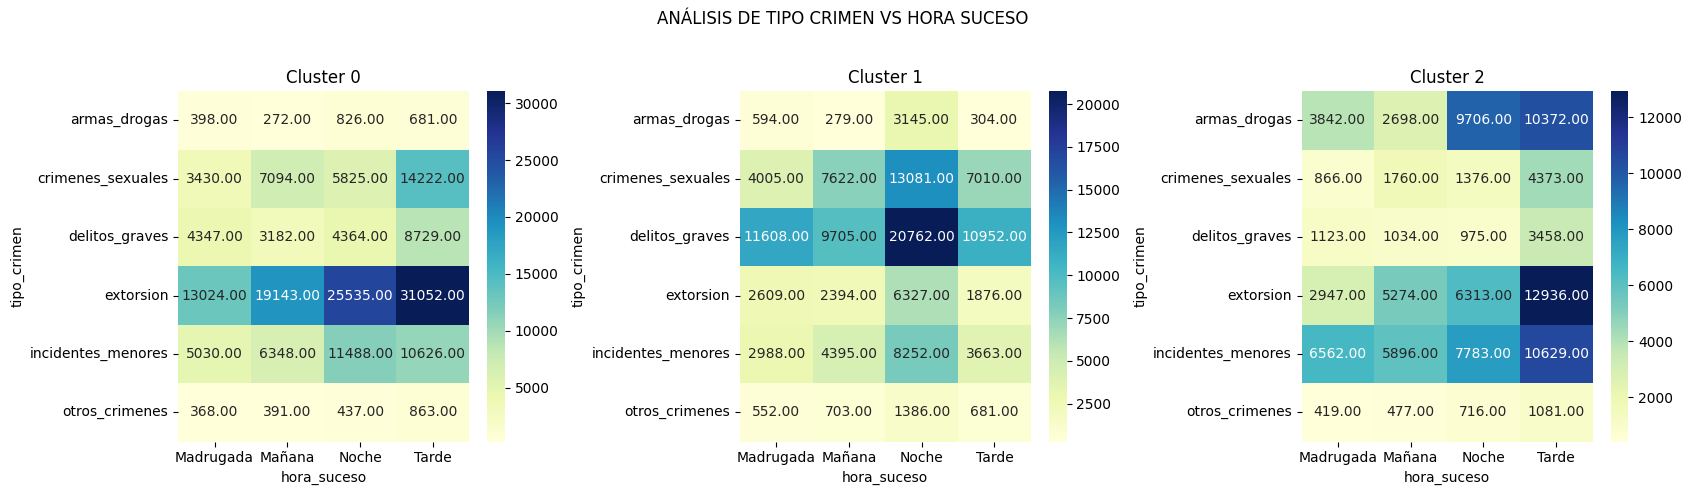

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (17,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(bronx_cluster_kmodes0['tipo_crimen'], bronx_cluster_kmodes0['hora_suceso'])
ct1 = pd.crosstab(bronx_cluster_kmodes1['tipo_crimen'], bronx_cluster_kmodes1['hora_suceso'])
ct2 = pd.crosstab(bronx_cluster_kmodes2['tipo_crimen'], bronx_cluster_kmodes2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

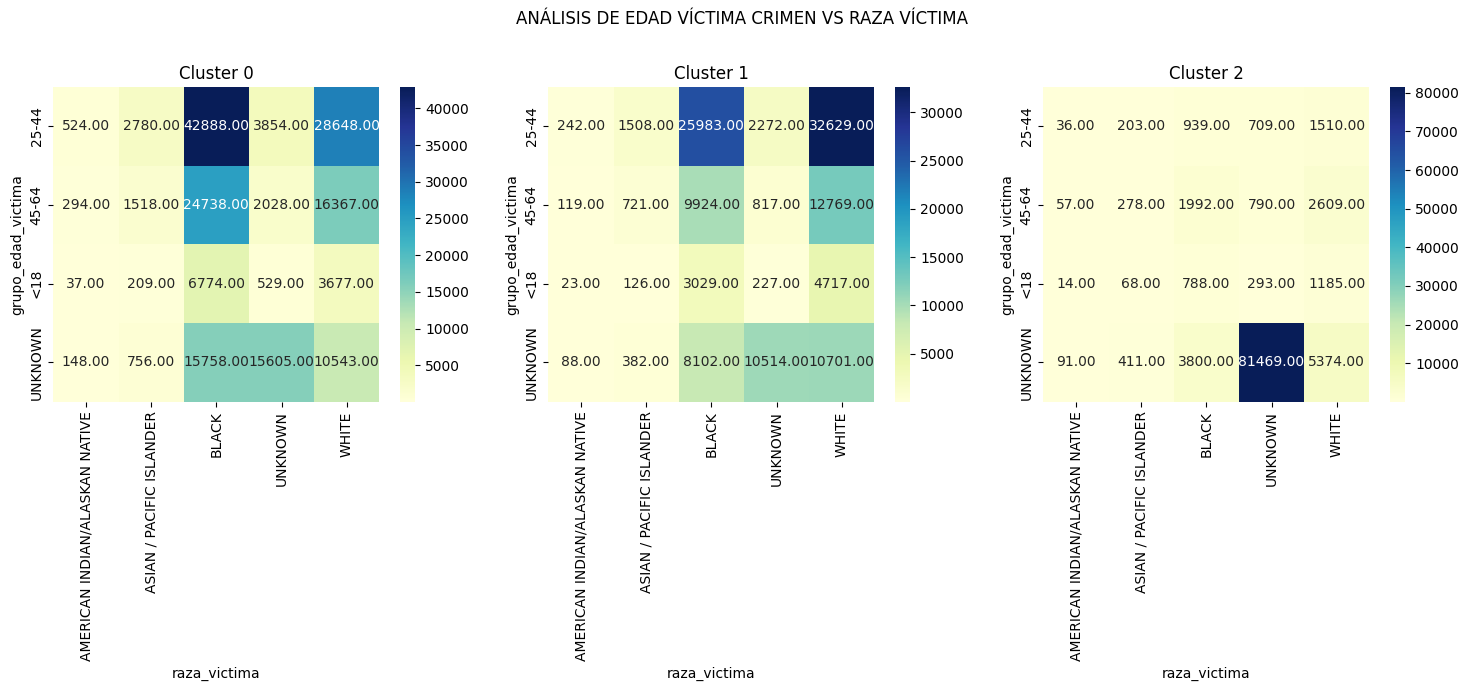

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(bronx_cluster_kmodes0['grupo_edad_victima'], bronx_cluster_kmodes0['raza_victima'])
ct1 = pd.crosstab(bronx_cluster_kmodes1['grupo_edad_victima'], bronx_cluster_kmodes1['raza_victima'])
ct2 = pd.crosstab(bronx_cluster_kmodes2['grupo_edad_victima'], bronx_cluster_kmodes2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

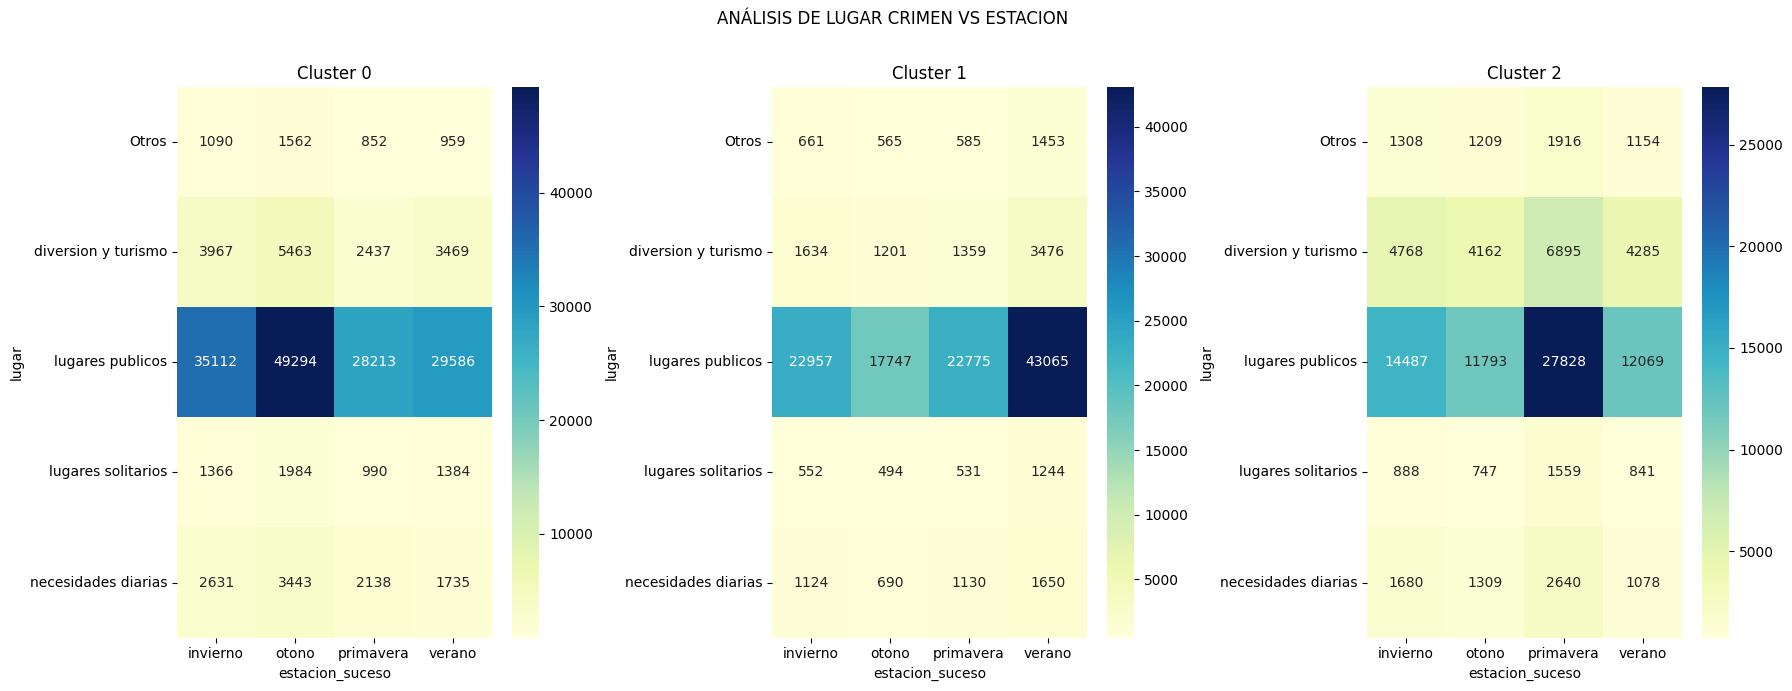

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (18,7))
fig.suptitle('ANÁLISIS DE LUGAR CRIMEN VS ESTACION \n')
ct0 = pd.crosstab(bronx_cluster_kmodes0['lugar'], bronx_cluster_kmodes0['estacion_suceso'])
ct1 = pd.crosstab(bronx_cluster_kmodes1['lugar'], bronx_cluster_kmodes1['estacion_suceso'])
ct2 = pd.crosstab(bronx_cluster_kmodes2['lugar'], bronx_cluster_kmodes2['estacion_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

In [ ]:
for column in categoricas_bronx.columns:
  if column not in ['labels', 'latitud', 'longitud']:
    print(f"Variable {column}:")
    display(categoricas_bronx.groupby(['labels', column]).size().reset_index().rename(columns = {0:'casos'}))
    print('\n')

Variable hora_suceso:


,labels,hora_suceso,casos
0,0,Madrugada,26597
1,0,Mañana,36430
2,0,Noche,48475
3,0,Tarde,66173
4,1,Madrugada,22356
5,1,Mañana,25098
6,1,Noche,52953
7,1,Tarde,24486
8,2,Madrugada,15759
9,2,Mañana,17139




Variable grupo_edad_sospechoso:


,labels,grupo_edad_sospechoso,casos
0,0,25-44,11743
1,0,45-64,7183
2,0,<18,4067
3,0,UNKNOWN,154682
4,1,25-44,71594
5,1,45-64,16775
6,1,<18,6355
7,1,UNKNOWN,30169
8,2,25-44,28865
9,2,45-64,14031




Variable raza_sospechoso:


,labels,raza_sospechoso,casos
0,0,AMERICAN INDIAN/ALASKAN NATIVE,156
1,0,ASIAN / PACIFIC ISLANDER,721
2,0,BLACK,32613
3,0,UNKNOWN,129141
4,0,WHITE,15044
5,1,AMERICAN INDIAN/ALASKAN NATIVE,323
6,1,ASIAN / PACIFIC ISLANDER,1419
7,1,BLACK,79929
8,1,UNKNOWN,6345
9,1,WHITE,36877




Variable sexo_sospechoso:


,labels,sexo_sospechoso,casos
0,0,Desconocido,119432
1,0,Femenino,24254
2,0,Masculino,33989
3,1,Desconocido,2724
4,1,Femenino,26006
5,1,Masculino,96163
6,2,Desconocido,19433
7,2,Femenino,14571
8,2,Masculino,68612




Variable grupo_edad_victima:


,labels,grupo_edad_victima,casos
0,0,25-44,78694
1,0,45-64,44945
2,0,<18,11226
3,0,UNKNOWN,42810
4,1,25-44,62634
5,1,45-64,24350
6,1,<18,8122
7,1,UNKNOWN,29787
8,2,25-44,3397
9,2,45-64,5726




Variable raza_victima:


,labels,raza_victima,casos
0,0,AMERICAN INDIAN/ALASKAN NATIVE,1003
1,0,ASIAN / PACIFIC ISLANDER,5263
2,0,BLACK,90158
3,0,UNKNOWN,22016
4,0,WHITE,59235
5,1,AMERICAN INDIAN/ALASKAN NATIVE,472
6,1,ASIAN / PACIFIC ISLANDER,2737
7,1,BLACK,47038
8,1,UNKNOWN,13830
9,1,WHITE,60816




Variable sexo_victima:


,labels,sexo_victima,casos
0,0,Femenino,86190
1,0,Masculino,79128
2,0,Transgenero,12357
3,1,Femenino,76181
4,1,Masculino,40666
5,1,Transgenero,8046
6,2,Femenino,10420
7,2,Masculino,15131
8,2,Transgenero,77065




Variable tipo_crimen:


,labels,tipo_crimen,casos
0,0,armas_drogas,2177
1,0,crimenes_sexuales,30571
2,0,delitos_graves,20622
3,0,extorsion,88754
4,0,incidentes_menores,33492
5,0,otros_crimenes,2059
6,1,armas_drogas,4322
7,1,crimenes_sexuales,31718
8,1,delitos_graves,53027
9,1,extorsion,13206




Variable lugar:


,labels,lugar,casos
0,0,Otros,4463
1,0,diversion y turismo,15336
2,0,lugares publicos,142205
3,0,lugares solitarios,5724
4,0,necesidades diarias,9947
5,1,Otros,3264
6,1,diversion y turismo,7670
7,1,lugares publicos,106544
8,1,lugares solitarios,2821
9,1,necesidades diarias,4594




Variable dia_suceso:


,labels,dia_suceso,casos
0,0,domingo,23658
1,0,jueves,24837
2,0,lunes,26127
3,0,martes,22375
4,0,miercoles,25611
5,0,sabado,20870
6,0,viernes,34197
7,1,domingo,19086
8,1,jueves,17033
9,1,lunes,17518




Variable estacion_suceso:


,labels,estacion_suceso,casos
0,0,invierno,44166
1,0,otono,61746
2,0,primavera,34630
3,0,verano,37133
4,1,invierno,26928
5,1,otono,20697
6,1,primavera,26380
7,1,verano,50888
8,2,invierno,23131
9,2,otono,19220




Variable mes_suceso:


,labels,mes_suceso,casos
0,0,abril,9692
1,0,agosto,10796
2,0,diciembre,40804
3,0,febrero,13730
4,0,julio,12860
5,0,junio,12878
6,0,marzo,12157
7,0,mayo,12060
8,0,noviembre,19694
9,0,octubre,19527
